In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

torch.manual_seed(111)
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='cuda')

- transforms.ToTensor() converts the data to a PyTorch tensor.
- transforms.Normalize() converts the range of the 
tensor coefficients.

The arguments of transforms.Normalize() are two tuples, (M₁, ..., Mₙ) and (S₁, ..., Sₙ), with n representing the number of channels of the images. Grayscale images such as those in MNIST dataset have only one channel, so the tuples have only one value. Then, for each channel i of the image, transforms.Normalize() subtracts Mᵢ from the coefficients and divides the result by Sᵢ.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

In [3]:
train_set

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [4]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)
train_loader

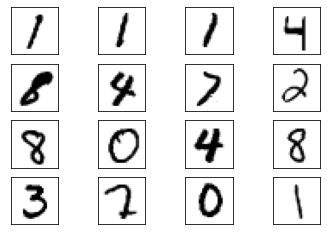

In [5]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

# Original GAN

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256), # the random/noise input is greater this time
            nn.ReLU(),
            
            nn.Linear(256, 512),
            nn.ReLU(),
            
            nn.Linear(512, 1024),
            nn.ReLU(),
            
            # Tanh() as the activation of the output layer since the output 
            # coefficients should be in the interval from -1 to 1
            nn.Linear(1024, 784),
            nn.Tanh(), 
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [17]:
discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)

lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [27]:
import numpy as np
gan_probs = []
gan_loss = []
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch}\t Loss D.: {loss_discriminator} Loss G.: {loss_generator}")
            probs = output_discriminator_generated.cpu().detach()
            l = np.log(1 - probs).mean()
            gan_probs.append(probs.mean())
            gan_loss.append(l)

Epoch: 0	 Loss D.: 0.6598582863807678 Loss G.: 1.1470974683761597
Epoch: 1	 Loss D.: 0.5229203104972839 Loss G.: 1.0307083129882812
Epoch: 2	 Loss D.: 0.6357079744338989 Loss G.: 0.9276307821273804
Epoch: 3	 Loss D.: 0.5266848206520081 Loss G.: 1.0305275917053223
Epoch: 4	 Loss D.: 0.5716484785079956 Loss G.: 1.1826832294464111
Epoch: 5	 Loss D.: 0.668267548084259 Loss G.: 0.9095688462257385
Epoch: 6	 Loss D.: 0.5434049367904663 Loss G.: 1.0334296226501465
Epoch: 7	 Loss D.: 0.61187744140625 Loss G.: 0.8850452899932861
Epoch: 8	 Loss D.: 0.5730170607566833 Loss G.: 1.0410983562469482
Epoch: 9	 Loss D.: 0.6799784898757935 Loss G.: 1.0090618133544922
Epoch: 10	 Loss D.: 0.6254280805587769 Loss G.: 0.961704432964325
Epoch: 11	 Loss D.: 0.6694013476371765 Loss G.: 1.1174839735031128
Epoch: 12	 Loss D.: 0.57073575258255 Loss G.: 1.1112734079360962
Epoch: 13	 Loss D.: 0.5693306922912598 Loss G.: 0.9133699536323547
Epoch: 14	 Loss D.: 0.5566889047622681 Loss G.: 0.9338333606719971
Epoch: 15	 

In [28]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

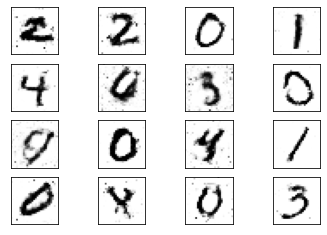

In [30]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

# Condiitional GAN  

In [ ]:
class CDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out #.squeeze()

class CGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 1, 28, 28)


In [ ]:

discriminator = CDiscriminator().to(device=device)
generator = CGenerator().to(device=device)

lr = 1e-4
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

import numpy as np
g_epoch_loss = []
d_epoch_loss = []

# pode ficar fora porque len(dataset) % batch_size == 0
real_labels = torch.ones((batch_size,1)).to(device=device)
fake_labels = torch.zeros((batch_size, 1)).to(device=device)
real_fake_labels = torch.cat((real_labels, fake_labels)).to(device=device)

In [ ]:
for epoch in range(num_epochs):
    D_loss_list, G_loss_list = [], []
    for n, (mnist_images, mnist_labels) in enumerate(train_loader):
        mnist_images = mnist_images.to(device=device)
        mnist_labels = mnist_labels.to(device=device)

        # training discriminator
        optimizer_discriminator.zero_grad()
        z = torch.randn((batch_size, 100)).to(device=device)
        gen_labels = torch.randint(0, 10, (batch_size, 1)).reshape(-1).to(device=device)
        gen_images = generator(z, gen_labels)

        all_samples = torch.cat((mnist_images, gen_images))
        all_labels = torch.cat((mnist_labels, gen_labels))

        predicted_labels = discriminator(all_samples, all_labels) # classifying true/fake
        d_loss = loss_function(predicted_labels, real_fake_labels)
        d_loss.backward()
        optimizer_discriminator.step()
        D_loss_list.append(d_loss.item())

        # training generator
        optimizer_generator.zero_grad()
        z = torch.randn((batch_size, 100)).to(device=device)
        gen_labels = torch.randint(0, 10, (batch_size, 1)).reshape(-1).to(device=device)
        gen_images = generator(z, gen_labels)

        predicted_labels = discriminator(gen_images, gen_labels) 
        g_loss = loss_function(predicted_labels, real_labels) # trying to fool the discriminator
        g_loss.backward()
        optimizer_generator.step()
        G_loss_list.append(g_loss.item())
    print(f"Epoch: {epoch}\t Loss D.: {np.mean(D_loss_list)} Loss G.: {np.mean(G_loss_list)}")
    g_epoch_loss.append(np.mean(G_loss_list))
    d_epoch_loss.append(np.mean(D_loss_list))
    if np.mean(G_loss_list) < 0.1:
        break

In [ ]:
z = torch.randn(100, 100).cuda()
labels = torch.LongTensor([i for i in range(10) for _ in range(10)]).cuda()
images = generator(z, labels).cpu().detach()
for i in range(100):
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow(images[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])
plt.show()